In [12]:
import numpy as np 
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from matplotlib import gridspec
import load_ship_data
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier  

from sklearn.model_selection import KFold

In [2]:
np.random.seed(522)

In [3]:
# Load the data! 
filePath = './data/shipsnet.json'
trainingSet, testingSet, validationSet = load_ship_data.load_data_train_test_split(filePath)
train, labels_tr = trainingSet
train_flat = train.reshape(train.shape[0], 19200)
train_flat[0][:10]

Training Set Data Length:  2800   Label Length:  2800
TestingSet Set Data Length:  600  Label Length:  600
Validation Set Data Length:  600  Label Length:  600


array([102,  99,  99, 103, 104, 100, 104, 105, 103, 108], dtype=uint8)

In [4]:
Xtrain=trainingSet[0]
ytrain=trainingSet[1]
Xtest=testingSet[0]
ytest=testingSet[1]
Xvalid=validationSet[0]
yvalid=validationSet[1]
Xtrain=Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1]*Xtrain.shape[2]*Xtrain.shape[3])
Xtest=Xtest.reshape(Xtest.shape[0],Xtest.shape[1]*Xtest.shape[2]*Xtest.shape[3])
Xvalid=Xvalid.reshape(Xvalid.shape[0],Xvalid.shape[1]*Xvalid.shape[2]*Xvalid.shape[3])

### Random Forest Implementation / Experimentation

In [5]:
from sklearn.ensemble import RandomForestClassifier
import time



In [6]:
def calculatePredictedVsActual(predicted, actual): 
    correctlyPredictedShips = 0
    correctlyPredictedNotShips = 0
    
    for i in np.arange(len(predicted)): 
        if (predicted[i] == 0 and actual[i] == 0): 
            correctlyPredictedNotShips = correctlyPredictedNotShips + 1
        elif (predicted[i] == 1 and actual[i] == 1): 
            correctlyPredictedShips = correctlyPredictedShips + 1
            
    totalShore = len(actual[ actual == 0 ])
    totalShips = len(actual[ actual == 1 ])

    return (correctlyPredictedNotShips / totalShore, correctlyPredictedShips / totalShips) 
    
def runRandomForestClassifier(xTrain, yTrain, xTest, yTest): 
    clf = RandomForestClassifier(warm_start=True, verbose=1)
    startingTime = time.time()           # start time
    y_model = clf.fit(xTrain, yTrain)
    endingTime = time.time()           # ending time
    totalTime = endingTime - startingTime

    
    return (y_model.score(xTest, yTest), totalTime, clf.predict(xTest))


def doKFoldCrossValidationRandomForest(X, y, xTest, yTest):
    k=10
    kf=KFold(n_splits=k,random_state=None)
    acc_scores=[]
    for train_index,test_index in kf.split(X):
        X_train,X_test=X[train_index,:],X[test_index,:]
        y_train,y_test=y[train_index],y[test_index]
        (accuracy, time, values) = runRandomForestClassifier(X_train, y_train, X_test, y_test)
        acc_scores.append(accuracy)
    avg_acc=sum(acc_scores)*1.0/k
    print('Accuracy from each fold =  {}'.format(acc_scores))
    print('Average Accuracy = {}'.format(avg_acc))

    return avg_acc


In [9]:
(basicRandomForestAccuracy, basicRandomForestRunTime, predicted) = runRandomForestClassifier(Xtrain, ytrain, Xtest, ytest)
kfoldAccRandomForest = doKFoldCrossValidationRandomForest(Xtrain, ytrain, Xtest, ytest)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Accuracy from each fold =  [0.9535714285714286, 0.9357142857142857, 0.9642857142857143, 0.9535714285714286, 0.9642857142857143, 0.9464285714285714, 0.9535714285714286, 0.95, 0.9607142857142857, 0.9392857142857143]
Average Accuracy = 0.9521428571428572


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [10]:
(class0Acc, class1Acc) = calculatePredictedVsActual(predicted, ytest)
print(f"""
basicRandomForestAccuracy {basicRandomForestAccuracy}
kfoldAccRandomForest {kfoldAccRandomForest}
class0Acc {class0Acc}, 
class1Acc {class1Acc}
""")



basicRandomForestAccuracy 0.96
kfoldAccRandomForest 0.9521428571428572
class0Acc 0.98, 
class1Acc 0.9



### PCA + Random Forest Implementation / Experimentation

In [11]:
def plotPCA(Xtrain, Xtest, ytrain, ytest):
    numComponentsList = [5, 10, 40, 50,75, 100, 250, 500, 700, 850, 1000, 2000, None]

    accuracyList = np.zeros(len(numComponentsList))
    runTimeList = np.zeros(len(numComponentsList))
    explainedList = np.zeros(len(numComponentsList))
    
    for i in np.arange(len(numComponentsList)): 
        pca = PCA(n_components=numComponentsList[i])
        pca.fit(Xtrain)
        pca_Xtrain= pca.transform(Xtrain)
        pca_Xtest = pca.transform(Xtest)
        explained=np.sum(pca.explained_variance_ratio_)
        print(explained)
        (pcaRandomForestAccuracy, pcaRandomForestRunTime, pcaPredicted) = runRandomForestClassifier(pca_Xtrain, ytrain, pca_Xtest, ytest)
        (class0, class1) = calculatePredictedVsActual(pcaPredicted, ytest)
        accuracyList[i] =pcaRandomForestAccuracy
        runTimeList[i] = pcaRandomForestRunTime
        explainedList[i] = explained
        print(f""" 
            PCA Components {numComponentsList[i]}
            pcaRandomForestAccuracy {pcaRandomForestAccuracy}
            pcaRandomForestRunTime {pcaRandomForestRunTime}
            explained {explained}
            class0 {class0}, 
            class1 {class1}
        
        """)
    fig, ax1= plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(numComponentsList, accuracyList, color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time', color=color)
    ax2.plot(numComponentsList, runTimeList, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title("PCA With Respect to Random Forest")
    return (accuracyList, runTimeList, explainedList)

0.6157238553120535


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 5
            pcaRandomForestAccuracy 0.9116666666666666
            pcaRandomForestRunTime 0.9605951309204102
            explained 0.6157238553120535
            class0 0.96, 
            class1 0.7666666666666667
        
        
0.6997472370889533


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 10
            pcaRandomForestAccuracy 0.95
            pcaRandomForestRunTime 1.063364028930664
            explained 0.6997472370889533
            class0 0.9822222222222222, 
            class1 0.8533333333333334
        
        
0.8319549858282743


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


 
            PCA Components 40
            pcaRandomForestAccuracy 0.965
            pcaRandomForestRunTime 2.074150800704956
            explained 0.8319549858282743
            class0 0.9977777777777778, 
            class1 0.8666666666666667
        
        
0.849901026343648


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 50
            pcaRandomForestAccuracy 0.96
            pcaRandomForestRunTime 1.7937610149383545
            explained 0.849901026343648
            class0 0.9955555555555555, 
            class1 0.8533333333333334
        
        
0.880609851040148


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 75
            pcaRandomForestAccuracy 0.965
            pcaRandomForestRunTime 1.6277213096618652
            explained 0.880609851040148
            class0 0.9977777777777778, 
            class1 0.8666666666666667
        
        
0.9003295274163259


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 100
            pcaRandomForestAccuracy 0.9516666666666667
            pcaRandomForestRunTime 2.3237059116363525
            explained 0.9003295274163259
            class0 0.9955555555555555, 
            class1 0.82
        
        
0.9535107579466414


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 250
            pcaRandomForestAccuracy 0.9433333333333334
            pcaRandomForestRunTime 2.9054291248321533
            explained 0.9535107579466414
            class0 1.0, 
            class1 0.7733333333333333
        
        
0.980248322258303


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 500
            pcaRandomForestAccuracy 0.9183333333333333
            pcaRandomForestRunTime 4.390632390975952
            explained 0.980248322258303
            class0 1.0, 
            class1 0.6733333333333333
        
        
0.9882372750298958


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


 
            PCA Components 700
            pcaRandomForestAccuracy 0.9
            pcaRandomForestRunTime 5.901299953460693
            explained 0.9882372750298958
            class0 1.0, 
            class1 0.6
        
        
0.991564817446791


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 850
            pcaRandomForestAccuracy 0.8933333333333333
            pcaRandomForestRunTime 6.02516770362854
            explained 0.991564817446791
            class0 1.0, 
            class1 0.5733333333333334
        
        
0.9937807978734744


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 1000
            pcaRandomForestAccuracy 0.8833333333333333
            pcaRandomForestRunTime 6.218578815460205
            explained 0.9937807978734744
            class0 1.0, 
            class1 0.5333333333333333
        
        
0.9991700833210535


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components 2000
            pcaRandomForestAccuracy 0.7633333333333333
            pcaRandomForestRunTime 12.754895210266113
            explained 0.9991700833210535
            class0 0.9177777777777778, 
            class1 0.3
        
        
1.0000000000000002


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


 
            PCA Components None
            pcaRandomForestAccuracy 0.7116666666666667
            pcaRandomForestRunTime 15.396730899810791
            explained 1.0000000000000002
            class0 0.8177777777777778, 
            class1 0.3933333333333333
        
        


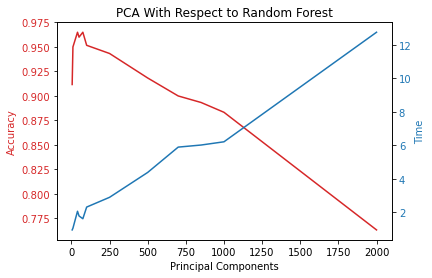

In [115]:
allVals = plotPCA(Xtrain, Xtest, ytrain, ytest)


kfolds! 

In [ ]:
def doKFoldCrossValidation(xTrain, yTrain, xValid, yValid, xTest, yTest, model):
    pca2 = PCA(n_components=50)
    Xtrain=np.concatenate((xTrain,xValid))
    ytrain=np.concatenate((yTrain,yValid))
    pca2.fit(Xtrain)
    pca2_Xtrain=pca2.transform(Xtrain)
    pca2_Xtest=pca2.transform(Xtest)
    explained=np.sum(pca2.explained_variance_ratio_)
    print(explained)
    X=pca2_Xtrain
    y=ytrain
    print(X.shape)
    print(y.shape)
    k=10
    kf=KFold(n_splits=k,random_state=None)
    acc_scores=[]
    for train_index,test_index in kf.split(X):
        X_train,X_test=X[train_index,:],X[test_index,:]
        y_train,y_test=y[train_index],y[test_index]
        (accuracy, time, values) = model(X_train, y_train, X_test, y_test)
        acc_scores.append(accuracy)
    avg_acc=sum(acc_scores)*1.0/k
    print('Accuracy from each fold =  {}'.format(acc_scores))
    print('Average Accuracy = {}'.format(avg_acc))
    
def doKFoldCrossValidationBPNN(X, y, xTest, yTest, model, bpnnModel):
    k=10
    kf=KFold(n_splits=k,random_state=None)
    acc_scores=[]
    for train_index,test_index in kf.split(X):
        X_train,X_test=X[train_index,:],X[test_index,:]
        y_train,y_test=y[train_index],y[test_index]
        (accuracy, time, values) = model(bpnnModel, X_train, y_train, X_test, y_test)
        acc_scores.append(accuracy)
    avg_acc=sum(acc_scores)*1.0/k
    print('Accuracy from each fold =  {}'.format(acc_scores))
    print('Average Accuracy = {}'.format(avg_acc))

    return avg_acc


In [41]:
doKFoldCrossValidation(Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest, runRandomForestClassifier)

0.8469330708334136
(3400, 50)
(3400,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Accuracy from each fold =  [0.9764705882352941, 0.9676470588235294, 0.9647058823529412, 0.9764705882352941, 0.961764705882353, 0.9588235294117647, 0.961764705882353, 0.9558823529411765, 0.9529411764705882, 0.9529411764705882]
Average Accuracy = 0.9629411764705882


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### BPNN Implementation / Experimentation

In [ ]:
bpnnClassifier_sgd = MLPClassifier(solver='sgd')
bpnnClassifier_lbfgs = MLPClassifier(solver='lbfgs')
bpnnWith1000Hidden_sgd = MLPClassifier(solver='sgd', hidden_layer_sizes=(1000,))
bpnnWith1000Hidden_lbfgs = MLPClassifier(solver='lbfgs',  hidden_layer_sizes=(1000,))
bpnnWith1000x1000Hidden_sgd = MLPClassifier(solver='sgd', hidden_layer_sizes=(1000,1000))
bpnnWith1000x1000Hidden_lbfgs = MLPClassifier(solver='lbfgs',  hidden_layer_sizes=(1000,1000))


In [ ]:
def runBPNNandTime(classifier, xTrain, yTrain, xTest, yTest): 
    startingTime = time.time()           # start time
    y_model = classifier.fit(xTrain, yTrain)
    endingTime = time.time()           # ending time
    totalTime = endingTime - startingTime
    
    return (y_model.score(xTest, yTest), totalTime, y_model.predict(xTest))
    


In [ ]:
xTrain = np.concatenate((Xtrain,Xvalid))
yTrain = np.concatenate((ytrain, yvalid))

(bpnnClassifier_sgd_accuracy, bpnnClassifier_sgd_time, bpnnClassifier_sgd_predicted) = runBPNNandTime(bpnnClassifier_sgd, xTrain, yTrain, Xtest, ytest)
(bpnnClassifier_lbfgs_accuracy, bpnnClassifier_lbfgs_time, bpnnClassifier_lbfgs_predicted) = runBPNNandTime(bpnnClassifier_lbfgs, xTrain, yTrain, Xtest, ytest)

(bpnnWith1000Hidden_sgd_accuracy, bpnnWith1000Hidden_sgd_time, bpnnWith1000Hidden_sgd_predicted) = runBPNNandTime(bpnnWith1000Hidden_sgd, xTrain, yTrain, Xtest, ytest)
(bpnnWith1000Hidden_lbfgs_accuracy, bpnnWith1000Hidden_lbfgs_time, bpnnWith1000Hidden_lbfgs_predicted) = runBPNNandTime(bpnnWith1000Hidden_lbfgs, xTrain, yTrain, Xtest, ytest)

(bpnnWith1000x1000Hidden_sgd_accuracy, bpnnWith1000x1000Hidden_sgd_time, bpnnWith1000x1000Hidden_sgd_predicted) = runBPNNandTime(bpnnWith1000x1000Hidden_sgd, xTrain, yTrain, Xtest, ytest)
(bpnnWith1000x1000Hidden_lbfgs_lbfgs_accuracy, bpnnWith1000x1000Hidden_lbfgs_time, bpnnWith1000x1000Hidden_lbfgs_predicted) = runBPNNandTime(bpnnWith1000x1000Hidden_lbfgs, xTrain, yTrain, Xtest, ytest)






In [98]:
np.save('bpnnPredicted', bpnnWith1000Hidden_lbfgs_predicted)

In [118]:
print(f"""
bpnnClassifier_sgd_accuracy: {bpnnClassifier_sgd_accuracy}    
bpnnClassifier_sgd_time: {bpnnClassifier_sgd_time}
bpnnClassifier_sgd_predicted {calculatePredictedVsActual(bpnnClassifier_sgd_predicted, ytest)}

bpnnWith1000Hidden_sgd_accuracy: {bpnnWith1000Hidden_sgd_accuracy}
bpnnWith1000Hidden_sgd_time: {bpnnWith1000Hidden_sgd_time}
bpnnWith1000Hidden__sgd_predicted {calculatePredictedVsActual(bpnnWith1000Hidden_sgd_predicted, ytest)}


bpnnWith1000x1000Hidden_sgd_accuracy: {bpnnWith1000x1000Hidden_sgd_accuracy}
bpnnWith1000x1000Hidden_sgd_time: {bpnnWith1000x1000Hidden_sgd_time}
bpnnWith1000x1000Hidden_sgd_predicted: {calculatePredictedVsActual(bpnnWith1000x1000Hidden_sgd_predicted, ytest)}



bpnnClassifier_lbfgs_accuracy: {bpnnClassifier_lbfgs_accuracy}
bpnnClassifier_lbfgs_time: {bpnnClassifier_lbfgs_time}
bpnnClassifier_lbfgs_predicted {calculatePredictedVsActual(bpnnClassifier_lbfgs_predicted, ytest)}

bpnnWith1000Hidden_lbfgs_accuracy: {bpnnWith1000Hidden_lbfgs_accuracy}
bpnnWith1000Hidden_lbfgs_time: {bpnnWith1000Hidden_lbfgs_time}
bpnnWith1000Hidden_lbfgs_predicted {calculatePredictedVsActual(bpnnWith1000Hidden_lbfgs_predicted, ytest)}


bpnnWith1000x1000Hidden_lbfgs_lbfgs_accuracy: {bpnnWith1000x1000Hidden_lbfgs_lbfgs_accuracy}
bpnnWith1000x1000Hidden_lbfgs_time: {bpnnWith1000x1000Hidden_lbfgs_time}
bpnnWith1000x1000Hidden_lbfgs_predicted {calculatePredictedVsActual(bpnnWith1000x1000Hidden_lbfgs_predicted, ytest)}

""")


bpnnClassifier_sgd_accuracy: 0.75    
bpnnClassifier_sgd_time: 34.72964096069336
bpnnClassifier_sgd_predicted (1.0, 0.0)

bpnnWith1000Hidden_sgd_accuracy: 0.75
bpnnWith1000Hidden_sgd_time: 1517.6399581432343
bpnnWith1000Hidden__sgd_predicted (1.0, 0.0)


bpnnWith1000x1000Hidden_sgd_accuracy: 0.75
bpnnWith1000x1000Hidden_sgd_time: 318.50302481651306
bpnnWith1000x1000Hidden_sgd_predicted: (1.0, 0.0)



bpnnClassifier_lbfgs_accuracy: 0.9516666666666667
bpnnClassifier_lbfgs_time: 698.9334049224854
bpnnClassifier_lbfgs_predicted (0.9644444444444444, 0.9133333333333333)

bpnnWith1000Hidden_lbfgs_accuracy: 0.95
bpnnWith1000Hidden_lbfgs_time: 4586.67370223999
bpnnWith1000Hidden_lbfgs_predicted (0.9666666666666667, 0.9)


bpnnWith1000x1000Hidden_lbfgs_lbfgs_accuracy: 0.75
bpnnWith1000x1000Hidden_lbfgs_time: 613.7555248737335
bpnnWith1000x1000Hidden_lbfgs_predicted (1.0, 0.0)




### PCA + BPNN Implementation / Experimentation

In [161]:
def plotPCABpnn(Xtrain, Xtest, ytrain, ytest, model):
    numComponentsList = [ 50, 100, 250, 500, 850 ]

    accuracyList = np.zeros(len(numComponentsList))
    runTimeList = np.zeros(len(numComponentsList))
    explainedList = np.zeros(len(numComponentsList))
    kfoldsList = np.zeros(len(numComponentsList))
    
    for i in np.arange(len(numComponentsList)): 
        pca = PCA(n_components=numComponentsList[i])
        pca.fit(Xtrain)
        pca_Xtrain= pca.transform(Xtrain)
        pca_Xtest = pca.transform(Xtest)
        explained=np.sum(pca.explained_variance_ratio_)
        print(explained)
        (pcaBPNNAccuracy, pcaBPNNRuntime, pcaPredicted) = runBPNNandTime(model, pca_Xtrain, ytrain, pca_Xtest, ytest)
        kfoldAcc = doKFoldCrossValidationBPNN(pca_Xtrain, ytrain, pca_Xtest, ytest, runBPNNandTime, model)
        (class0, class1) = calculatePredictedVsActual(pcaPredicted, ytest)


        accuracyList[i] = pcaBPNNAccuracy
        runTimeList[i] = pcaBPNNRuntime
        explainedList[i] = explained
        kfoldsList[i] = kfoldAcc
        print(f""" 
            PCA Components {numComponentsList[i]}
            pcaBPNNAcc {pcaBPNNAccuracy}
            pcaBPNNRuntime {pcaBPNNRuntime}
            kfoldAcc       {kfoldAcc}
            explained      {explained}
            class0         {class0}
            class1         {class1}

        """)
    fig, ax1= plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(numComponentsList, accuracyList, color, label='Accuracy')
    ax1.plot(numComponentsList, kfoldsList, color='green', label='kFolds Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)
    
    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time', color=color)
    ax2.plot(numComponentsList, runTimeList, color=color, label='Run Time')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.show()
    
    
    return (accuracyList, runTimeList, explainedList, kfoldsList)

0.8469219012972105
Accuracy from each fold =  [0.9676470588235294, 0.9529411764705882, 0.9029411764705882, 0.9529411764705882, 0.8558823529411764, 0.961764705882353, 0.9058823529411765, 0.888235294117647, 0.9176470588235294, 0.65]
Average Accuracy = 0.8955882352941178
 
            PCA Components 50
            pcaBPNNAcc 0.955
            pcaBPNNRuntime 1.4789278507232666
            kfoldAcc       0.8955882352941178
            explained      0.8469219012972105
            class0         0.9555555555555556
            class1         0.9533333333333334

        
0.8973585970605596
Accuracy from each fold =  [0.9176470588235294, 0.9147058823529411, 0.9205882352941176, 0.8205882352941176, 0.9529411764705882, 0.9411764705882353, 0.9676470588235294, 0.9352941176470588, 0.95, 0.9294117647058824]
Average Accuracy = 0.925
 
            PCA Components 100
            pcaBPNNAcc 0.955
            pcaBPNNRuntime 2.3555498123168945
            kfoldAcc       0.925
            explained      0.89

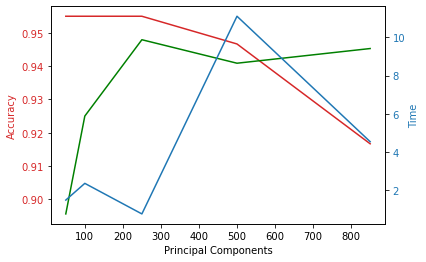

In [162]:
pcaValuesSGD = plotPCABpnn(xTrain, Xtest, yTrain, ytest, bpnnClassifier_sgd)


0.8469251463794587


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.9558823529411765, 0.9558823529411765, 0.9676470588235294, 0.9794117647058823, 0.6735294117647059, 0.9705882352941176, 0.9558823529411765, 0.9588235294117647, 0.9588235294117647, 0.9588235294117647]
Average Accuracy = 0.9335294117647059
 
            PCA Components 50
            pcaBPNNAcc 0.9616666666666667
            pcaBPNNRuntime 1.6081688404083252
            kfoldAcc       0.9335294117647059
            explained      0.8469251463794587
            class0         0.9666666666666667
            class1         0.9466666666666667

        
0.8973791623486245
Accuracy from each fold =  [0.9529411764705882, 0.9647058823529412, 0.9441176470588235, 0.9705882352941176, 0.961764705882353, 0.9647058823529412, 0.9676470588235294, 0.9558823529411765, 0.9647058823529412, 0.9558823529411765]
Average Accuracy = 0.9602941176470587
 
            PCA Components 100
            pcaBPNNAcc 0.9566666666666667
            pcaBPNNRuntime 4.442293882369995
            kfol

/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceW

Accuracy from each fold =  [0.95, 0.9676470588235294, 0.9588235294117647, 0.9647058823529412, 0.9676470588235294, 0.9205882352941176, 0.9705882352941176, 0.9676470588235294, 0.9529411764705882, 0.9588235294117647]
Average Accuracy = 0.9579411764705883
 
            PCA Components 500
            pcaBPNNAcc 0.95
            pcaBPNNRuntime 3.7528529167175293
            kfoldAcc       0.9579411764705883
            explained      0.9782074500515762
            class0         0.9577777777777777
            class1         0.9266666666666666

        
0.9901910972798614
Accuracy from each fold =  [0.9705882352941176, 0.9470588235294117, 0.9647058823529412, 0.9558823529411765, 0.961764705882353, 0.9676470588235294, 0.9411764705882353, 0.9558823529411765, 0.9705882352941176, 0.961764705882353]
Average Accuracy = 0.9597058823529411
 
            PCA Components 850
            pcaBPNNAcc 0.9583333333333334
            pcaBPNNRuntime 4.110856771469116
            kfoldAcc       0.959705882352941

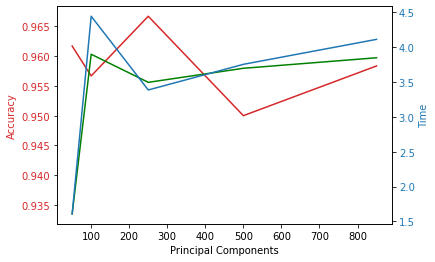

In [163]:
pcaValuesLBFGS = plotPCABpnn(xTrain,Xtest, yTrain, ytest, bpnnClassifier_lbfgs)


0.846927620377851
Accuracy from each fold =  [0.9058823529411765, 0.8794117647058823, 0.888235294117647, 0.95, 0.8529411764705882, 0.5235294117647059, 0.7411764705882353, 0.8470588235294118, 0.7470588235294118, 0.7411764705882353]
Average Accuracy = 0.8076470588235292
 
            PCA Components 50
            pcaBPNNAcc 0.9616666666666667
            pcaBPNNRuntime 4.2309889793396
            kfoldAcc       0.8076470588235292
            explained      0.846927620377851
            class0         0.9755555555555555
            class1         0.92

        
0.8973774936478844
Accuracy from each fold =  [0.9176470588235294, 0.8117647058823529, 0.8911764705882353, 0.9676470588235294, 0.9735294117647059, 0.8705882352941177, 0.8029411764705883, 0.9588235294117647, 0.8676470588235294, 0.9147058823529411]
Average Accuracy = 0.8976470588235292
 
            PCA Components 100
            pcaBPNNAcc 0.9316666666666666
            pcaBPNNRuntime 2.773685932159424
            kfoldAcc       0.8

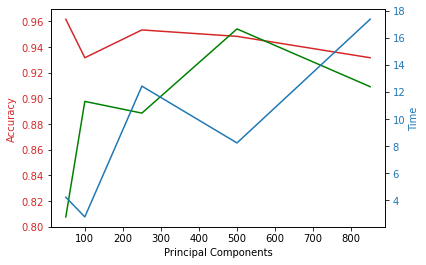

In [164]:
pcaValues_SGD_1000=plotPCABpnn(xTrain,Xtest, yTrain, ytest, bpnnWith1000Hidden_sgd)


In [ ]:
pcaValues_LBFGS_1000 = plotPCABpnn(xTrain,Xtest, yTrain, ytest, bpnnWith1000Hidden_lbfgs)


0.8469129600074904
Accuracy from each fold =  [0.961764705882353, 0.9735294117647059, 0.961764705882353, 0.9647058823529412, 0.9676470588235294, 0.9529411764705882, 0.9588235294117647, 0.9705882352941176, 0.961764705882353, 0.9705882352941176]
Average Accuracy = 0.9644117647058824
 
            PCA Components 50
            pcaBPNNAcc 0.9683333333333334
            pcaBPNNRuntime 11.947009086608887
            kfoldAcc       0.9644117647058824
            explained      0.8469129600074904
            class0         0.9755555555555555
            class1         0.9466666666666667

        
0.8974011828403449
Accuracy from each fold =  [0.9764705882352941, 0.9764705882352941, 0.9558823529411765, 0.9705882352941176, 0.9823529411764705, 0.9441176470588235, 0.9647058823529412, 0.8147058823529412, 0.9647058823529412, 0.9764705882352941]
Average Accuracy = 0.9526470588235293
 
            PCA Components 100
            pcaBPNNAcc 0.975
            pcaBPNNRuntime 12.625032901763916
           

/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy from each fold =  [0.9470588235294117, 0.9588235294117647, 0.9588235294117647, 0.961764705882353, 0.95, 0.9470588235294117, 0.9647058823529412, 0.9529411764705882, 0.9588235294117647, 0.9588235294117647]
Average Accuracy = 0.9558823529411764
 
            PCA Components 500
            pcaBPNNAcc 0.9633333333333334
            pcaBPNNRuntime 26.75769805908203
            kfoldAcc       0.9558823529411764
            explained      0.9782119963949706
            class0         0.9688888888888889
            class1         0.9466666666666667

        
0.9901867551476058


/Users/matthewlane/opt/anaconda3/envs/testEnv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Segmentation Experimentation

In [ ]:
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries

felzen = felzenszwalb(trainingSet[0][101].transpose(), scale=1000, sigma=1)
plt.imshow(mark_boundaries(trainingSet[0][101].transpose(), felzen))
np.unique(felzen, return_counts=True)

from skimage.segmentation import slic
slickBoy = slic((trainingSet[0][101].transpose()), n_segments=100, compactness=10)
plt.imshow(mark_boundaries(trainingSet[0][101].transpose(), slickBoy))

def segmentFeatures(segmentPixels): 
    features = []
    numberPixels, numBands = segmentPixels.shape
    
    for b in np.arange(numBands): 
        stats = scipy.stats.describe(segmentPixels[:,b])
    
    return features

segmentIDs = np.unique(slickBoy)
objects = []
objectIDs = []
for i in segmentIDs: 
    pixels = trainingSet[0][101].transpose()[slickBoy == i] 
    print('pixels for id', i, pixels.shape)
    objectFeatures = segmentFeatures(pixels)
    objects.append(objectFeatures)
    objectIDs.append(i)